In [55]:
# load libraries

import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge

from action_prediction import constants as const
from action_prediction.data import DataSet
from action_prediction import visualize as vis
from action_prediction import inter_subject_congruency as isc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# initialize class 
data = DataSet(task='social_prediction')

# load behavior
df_behav = data.load_behav()

# load eyetracking
df_eye = data.load_eye(data_type='events')

# merge eyetracking with behav
df_merged = data.merge_behav_eye(dataframe_behav=df_behav, dataframe_eye=df_eye)


In [9]:
# initialize plotting style
vis.plotting_style()

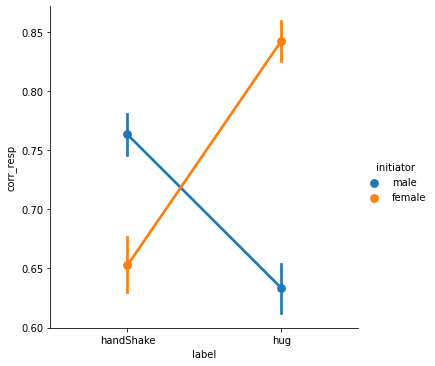

In [64]:
# visualize accuracy across runs
vis.plot_acc(dataframe=df_behav, x='run_num', hue='None')

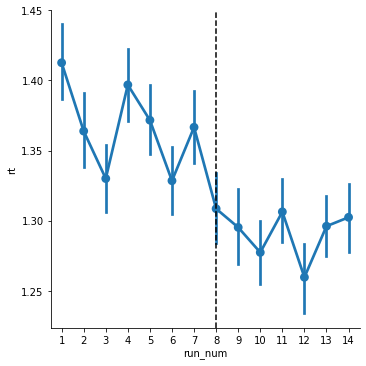

In [63]:
# visualize rt across runs
vis.plot_rt(dataframe=df_behav, x='run_num', hue=None)

In [ ]:
# plot diameter
# vis.plot_diameter(dataframe=df_merged)

## Visualization of Correlations
Another approach that visualizes correlations between subjects

reference source: https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3

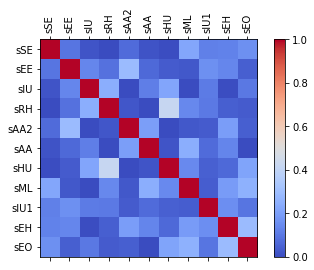

In [104]:
# get all subj fixations
fixations = isc.get_subj_fixations(dataframe=df_eye, data_type='events')

# grid subject data
gridded_data = isc.grid_all_subjects(fixations)

# visualize corr matrix
correlations = vis.visualize_corr(gridded_data)

# Inter-observer congruency

Idea: Build a saliency map from all observers except the ith observer. To calculate degree of similarity between ith observer and others, calculate hit rate. Iterate over all subjects and average scores to get the IOC.

Iterate over all fixation positions(x,y)
Convert fixation positions to gridded positions
For each grid position, map position to number of fixations in that grid position
Adaptive Binarization - yes or no whether some threshold number t or more fixations in that position

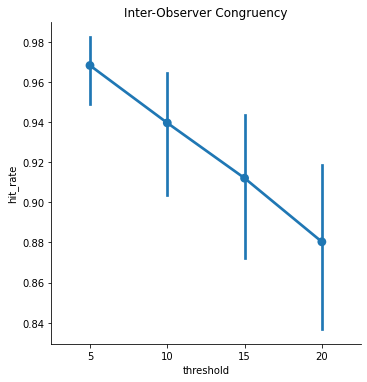

In [105]:
ioc_rates = isc.ioc(gridded_data=gridded_data, thresholds=[5, 10, 15, 20])

sns.factorplot(x='threshold', y='hit_rate', data=ioc_rates)
plt.title("Inter-Observer Congruency");

## Pairwise Comparison¶
To measure how much of a subject's fixations match with all other subjects'

Convert fixations to their locations in a grid
Since all the subjects have the same grid, the vectors being compared for each subject now all have the same length since each subject has one entry per grid position that contains the number of fixations at that position
Calculate correlation between each subject
Convert correlations to z-scores with Fisher Z-Transformation
Average z-scores
Convert to probabilities
Note on Fisher Z-Transformation:

The Fisher Z-Transformation is a way to transform the sampling distribution of Pearson’s r (i.e. the correlation coefficient) so that it becomes normally distributed. The “z” in Fisher Z stands for a z-score. The formula to transform r to a z-score is: z’ = .5[ln(1+r) – ln(1-r)]

<AxesSubplot:xlabel='observer', ylabel='avrg_zscore'>

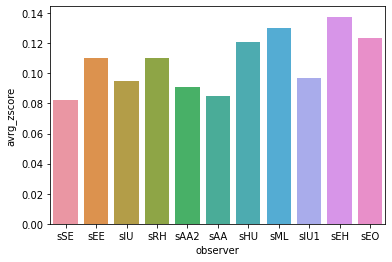

In [106]:
results = isc.pairwise(gridded_data)

sns.barplot(x='observer', y='avrg_zscore', data=results)
# sns.lineplot(x='observer', y='probability', data=results)

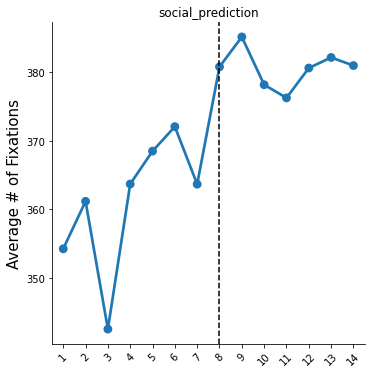

In [57]:
# plot fixation count
vis.plot_fixation_count(dataframe=df_merged, x='run_num', hue=None)  

In [65]:
# plot saccade count
# vis.plot_saccade_count(dataframe=df_merged, x='run_num', hue=None)

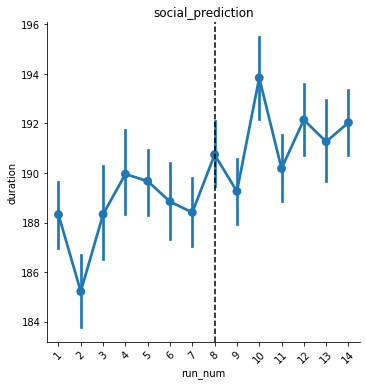

In [66]:
# plot fixation duration
vis.plot_fixation_duration(dataframe=df_merged, x='run_num', hue=None)

In [67]:
# plot amplitude
# vis.plot_amplitude(dataframe=df_merged, x='label', hue='condition_name')

In [68]:
# plot dispersion
# vis.plot_dispersion(dataframe=df_merged, x='run_num', hue=None)

In [69]:
# plot peak velocity
# vis.plot_peak_velocity(dataframe=df_merged, x='label', hue=None)

In [ ]:
# heatmap

# one subj, one run
for run in range(14):
    tmp = df_eye[(df_eye['subj']=='sIU') & (df_eye['run_num']==run+1) & (df_eye['type']=="fixations")]
    vis.plot_gaze_positions(dataframe=tmp)
    plt.title(f'run{run+1}')

In [92]:
df = df_merged.groupby(['subj', 'sess', 'run_num','type', 'actors', 'label', 'condition_name']
                      ).agg({'rt': 'mean',
                            'corr_resp': 'mean', 
                            'dispersion': 'mean', 
                            'amplitude': 'mean', 
                            'peak_velocity': 'mean', 
                            'duration': 'mean'}
                           ).reset_index()

In [109]:
# model data

model = LinearRegression()
model.fit(df[['corr_resp']], df[['rt']])
predictions = model.predict(df[['corr_resp']])

(2948, 1)